# Question 2
## Using ADQL to Search for Bright Stars Around the Open Cluster M67

A colleague is interestded in the open cluster Messier 67 (RA = 132.825 deg, Dec = 11.8 deg) and is considering an observation proposal using the 2dF fibre positioner and HERMES spectrograph (effective for Gaia G band magnitudes < 14). They need to know if there are enough bright stars in this region for observation. Your task is to assist by querying data from Gaia DR3 and performing some basic analysis.

* Download all stars within 1 degree of the centre of Messier 67 that are brighter than G = 14 in Gaia DR3 and include a cross match with the 2MASS catalogue and report your ADQL query text

In [40]:
from astroquery.gaia import Gaia
import pandas as pd

query = f"""
SELECT *
FROM gaiadr3.gaia_source AS gaia
JOIN gaiaedr3.tmass_psc_xsc_best_neighbour AS xmatch USING (source_id)
JOIN gaiaedr3.tmass_psc_xsc_join AS xjoin USING (clean_tmass_psc_xsc_oid)
JOIN gaiadr1.tmass_original_valid AS tmass
    ON xjoin.original_psc_source_id = tmass.designation

WHERE CONTAINS(
        POINT(gaia.ra, gaia.dec), 
        CIRCLE(132.825, 11.8, 1.0)
) = 1
    AND gaia.phot_g_mean_mag < 14
ORDER BY gaia.phot_g_mean_mag
"""

job = Gaia.launch_job(query)
results = job.get_results()

* Determine how many stars are returned from the initial query

In [44]:
print(f"Number of stars from the initial query is: {len(results)} stars")

Number of stars from the initial query is: 1018 stars


* Identify any stars with bad 2MASS photometry, where ph_phal is not 'AAA'

In [45]:
# Filtering stars with bad 2MASS photometry (where ph_qual is not 'AAA')
bad_photometry = results[results['ph_qual'] != 'AAA']
print(f"Number of stars with bad 2MASS photometry: {len(bad_photometry)}")

Number of stars with bad 2MASS photometry: 21


* Identify any stars with negative (or non-positive) parallaxes in the Gaia data

In [46]:
# Filtering stars with non-positive parallaxes
non_positive_parallax = results[results['parallax'] <= 0]
print(f"Number of stars with non-positive parallaxes: {len(non_positive_parallax)}")

Number of stars with non-positive parallaxes: 2


* Apply these two quality cuts (removing stars with bad 2MASS photometry and non-positive parallaxes). After applying the cuts, determine how many stars remain

In [47]:
# Apply the two cuts: remove stars with bad 2MASS photometry and non-positive parallaxes
good_stars = results[(results['ph_qual'] == 'AAA') & (results['parallax'] > 0)]
print(f"Number of stars after quality cuts: {len(good_stars)}")

Number of stars after quality cuts: 988


* Using the remaining stars, generate a figure with two panels (1 point per panel):

> (a) A color-magnitude (CMB) of Gaia BP-RP vs. absolute G magnitude

> (b) A 2MASS J-Ks vs. apparent K magnitude diagram.

* Save the figure as 'figures/cmds_M67.png' with a resolution of 200 dots per inch.

Formula for Absolute Magnitude:
$$ M_G = G - 5\log_{10}(d/10) $$
with $ d = 1000/\text{parallax} $

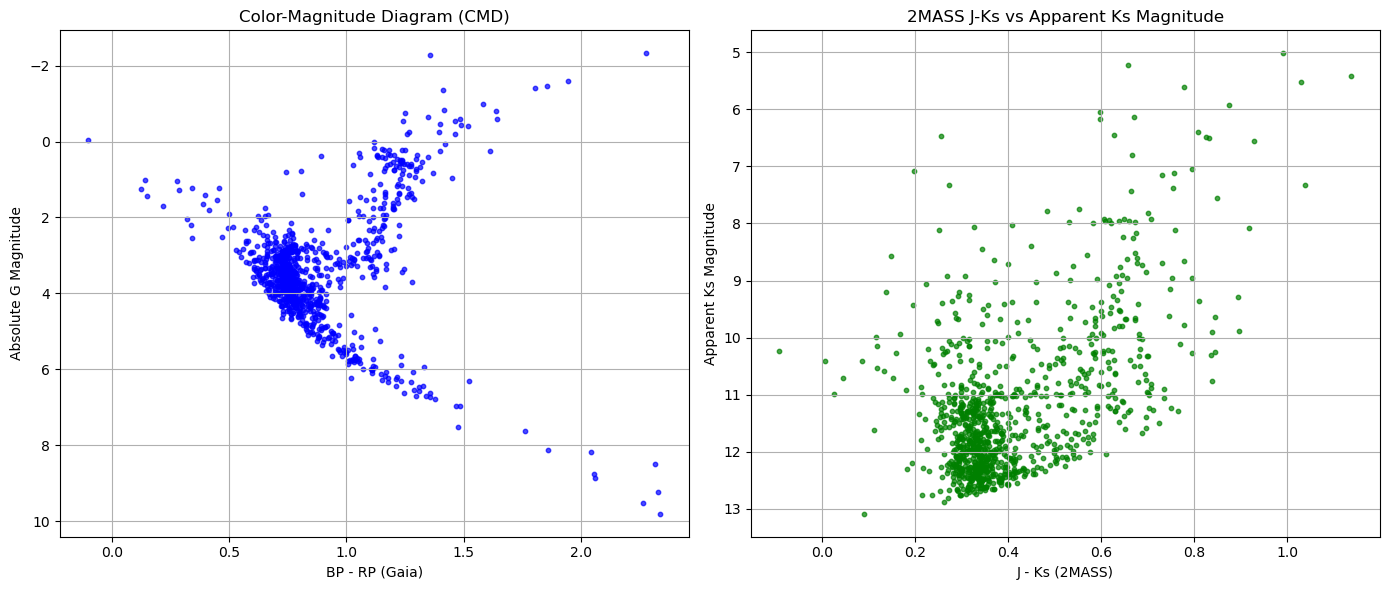

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate BP - RP color and absolute G magnitude for Gaia
bp_rp = good_stars['phot_bp_mean_mag'] - good_stars['phot_rp_mean_mag']
distance = 1000 / good_stars['parallax']  # Distance in parsecs
absolute_g = good_stars['phot_g_mean_mag'] - 5 * np.log10(distance) + 5

# Calculate J - Ks color and apparent Ks magnitude for 2MASS
j_ks = good_stars['j_m'] - good_stars['ks_m']
apparent_ks = good_stars['ks_m']

# Create a figure with two panels
fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# Panel 1: Color-Magnitude Diagram (CMD) - Gaia BP-RP vs Absolute G Magnitude
axs[0].scatter(bp_rp, absolute_g, c='blue', s=10, alpha=0.7)
axs[0].invert_yaxis()  # Invert y-axis to have brighter stars at the top
axs[0].set_xlabel('BP - RP (Gaia)')
axs[0].set_ylabel('Absolute G Magnitude')
axs[0].set_title('Color-Magnitude Diagram (CMD)')
axs[0].grid(True)

# Panel 2: 2MASS J-Ks vs Apparent Ks Magnitude Diagram
axs[1].scatter(j_ks, apparent_ks, c='green', s=10, alpha=0.7)
axs[1].invert_yaxis()  # Invert y-axis to have brighter stars at the top
axs[1].set_xlabel('J - Ks (2MASS)')
axs[1].set_ylabel('Apparent Ks Magnitude')
axs[1].set_title('2MASS J-Ks vs Apparent Ks Magnitude')
axs[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure as a PNG file with 200 DPI
plt.savefig('figures/cmds_M67.png', dpi=200)

# Show the figure
plt.show()

* Give you colleague a recommendation for the potential propsal when only judging the fibre usage.

In [53]:
print(f"Based on the remaining {len(good_stars)} stars after quality cuts, there are sufficient bright stars around Messier 67 for the 2dF fibre positioner and HERMES spectrograph.")

Based on the remaining 988 stars after quality cuts, there are sufficient bright stars around Messier 67 for the 2dF fibre positioner and HERMES spectrograph.
